In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
dev = qml.device("cirq.mixedsimulator", wires=2)

In [4]:
# CHSH observables
A1 = qml.PauliZ(0)
A2 = qml.PauliX(0)
B1 = qml.Hermitian(np.array([[1, 1], [1, -1]]) / np.sqrt(2), wires=1)
B2 = qml.Hermitian(np.array([[1, -1], [-1, -1]]) / np.sqrt(2), wires=1)
CHSH_observables = [A1 @ B1, A1 @ B2, A2 @ B1, A2 @ B2]

In [5]:
# subcircuit for creating an entangled pair of qubits
def bell_pair():
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])

In [10]:
@qml.qnode(dev)
def measure_A1B1():
    bell_pair()
    return qml.expval(A1 @ B1)

@qml.qnode(dev)
def measure_A1B2():
    bell_pair()
    return qml.expval(A1 @ B2)

@qml.qnode(dev)
def measure_A2B1():
    bell_pair()
    return qml.expval(A2 @ B1)

@qml.qnode(dev)
def measure_A2B2():
    bell_pair()
    return qml.expval(A2 @ B2)

circuits = qml.QNodeCollection([measure_A1B1,
                                measure_A1B2,
                                measure_A2B1,
                                measure_A2B2])

In [11]:
# now we measure each circuit and construct the CHSH inequality
expvals = circuits()

# The CHSH operator is A1 @ B1 + A1 @ B2 + A2 @ B1 - A2 @ B2
CHSH_expval = np.sum(expvals[:3]) - expvals[3]
print(CHSH_expval)

2.828426718711853


In [12]:
from pennylane_cirq import ops as cirq_ops
# Note that the 'Operation' op is a generic base class
# from PennyLane core.
# All other ops are provided by Cirq.
available_ops = [op for op in dir(cirq_ops) if not op.startswith('_')]
print("\n".join(available_ops))

AmplitudeDamp
BitFlip
CPhase
Depolarize
ISWAP
Operation
PhaseDamp
PhaseFlip


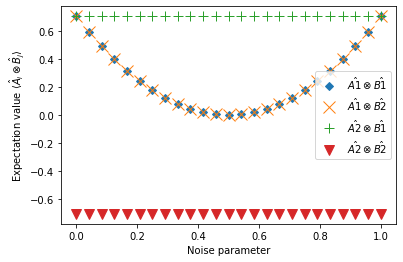

In [13]:
noise_vals = np.linspace(0, 1, 25)

CHSH_vals = []
noisy_expvals = []

for p in noise_vals:
    # we overwrite the bell_pair() subcircuit to add
    # extra noisy channels after the entangled state is created
    def bell_pair():
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0, 1])
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)
    # measuring the circuits will now use the new noisy bell_pair() function
    expvals = circuits()
    noisy_expvals.append(expvals)
noisy_expvals = np.array(noisy_expvals)
CHSH_expvals = np.sum(noisy_expvals[:,:3], axis=1) - noisy_expvals[:,3]

# Plot the individual observables
plt.plot(noise_vals, noisy_expvals[:, 0], 'D',
         label = r"$\hat{A1}\otimes \hat{B1}$", markersize=5)
plt.plot(noise_vals, noisy_expvals[:, 1], 'x',
         label = r"$\hat{A1}\otimes \hat{B2}$", markersize=12)
plt.plot(noise_vals, noisy_expvals[:, 2], '+',
         label = r"$\hat{A2}\otimes \hat{B1}$", markersize=10)
plt.plot(noise_vals, noisy_expvals[:, 3], 'v',
         label = r"$\hat{A2}\otimes \hat{B2}$", markersize=10)
plt.xlabel('Noise parameter')
plt.ylabel(r'Expectation value $\langle \hat{A}_i\otimes\hat{B}_j\rangle$')
plt.legend()
plt.show()

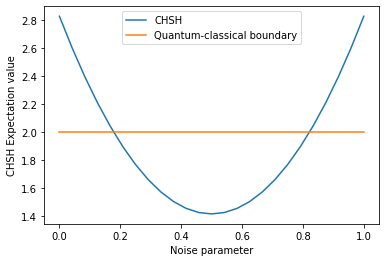

In [14]:
plt.plot(noise_vals, CHSH_expvals, label="CHSH")
plt.plot(noise_vals, 2 * np.ones_like(noise_vals),
         label="Quantum-classical boundary")
plt.xlabel('Noise parameter')
plt.ylabel('CHSH Expectation value')
plt.legend()
plt.show()

In [15]:
@qml.qnode(dev)
def circuit(gate_params, noise_param=0.0):
    qml.RX(gate_params[0], wires=0)
    qml.RY(gate_params[1], wires=0)
    cirq_ops.Depolarize(noise_param, wires=0)
    return qml.expval(qml.PauliZ(0))

gate_pars = [0.54, 0.12]
print("Expectation value:", circuit(gate_pars))

Expectation value: 0.851540632545948


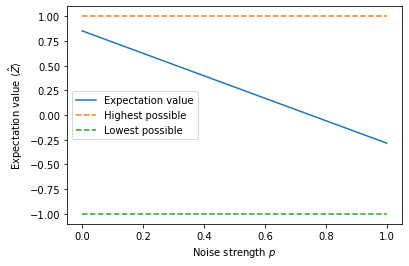

In [17]:
noise_vals = np.linspace(0., 1., 20)
expvals = [circuit(gate_pars, noise_param=p) for p in noise_vals]

plt.plot(noise_vals, expvals, label="Expectation value")
plt.plot(noise_vals, np.ones_like(noise_vals), '--', label="Highest possible")
plt.plot(noise_vals, -np.ones_like(noise_vals), '--', label="Lowest possible")
plt.ylabel(r"Expectation value $\langle \hat{Z} \rangle$")
plt.xlabel(r"Noise strength $p$")
plt.legend()
plt.show()

In [18]:
# declare the cost functions to be optimized
def cost(x):
    return circuit(x, noise_param=0.0)

def noisy_cost(x):
    return circuit(x, noise_param=0.3)

# initialize the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
init_params = np.array([0.011, 0.012])
noisy_circuit_params = init_params
params = init_params

for i in range(steps):
    # update the circuit parameters
    # we can optimize both in the same training loop
    params = opt.step(cost, params)
    noisy_circuit_params = opt.step(noisy_cost, noisy_circuit_params)

    if (i + 1) % 5 == 0:
        print("Step {:5d}. Cost: {: .7f}; Noisy Cost: {: .7f}".
              format(i + 1,
                     cost(params),
                     noisy_cost(noisy_circuit_params)))

print("\nOptimized rotation angles (noise-free case):")
print("({: .7f}, {: .7f})".format(*params))
print("Optimized rotation angles (noisy case):")
print("({: .7f}, {: .7f})".format(*noisy_circuit_params))

Step     5. Cost:  0.9961779; Noisy Cost:  0.5993173
Step    10. Cost:  0.8974948; Noisy Cost:  0.5941737
Step    15. Cost:  0.1440492; Noisy Cost:  0.5527687
Step    20. Cost: -0.1536868; Noisy Cost:  0.3309180
Step    25. Cost: -0.9152617; Noisy Cost:  0.0470152
Step    30. Cost: -0.9994047; Noisy Cost: -0.0519407
Step    35. Cost: -0.9999964; Noisy Cost: -0.2980615
Step    40. Cost: -1.0000000; Noisy Cost: -0.5561487
Step    45. Cost: -1.0000000; Noisy Cost: -0.5969037
Step    50. Cost: -1.0000000; Noisy Cost: -0.5997996
Step    55. Cost: -1.0000000; Noisy Cost: -0.5999871
Step    60. Cost: -1.0000000; Noisy Cost: -0.5999991
Step    65. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    70. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    75. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    80. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    85. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    90. Cost: -1.0000000; Noisy Cost: -0.6000000
Step    95. Cost: -1.0000000; Noisy Cost: -0.6

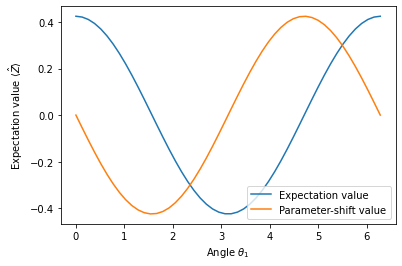

In [19]:
angles = np.linspace(0, 2 * np.pi, 50)
theta2 = np.pi / 4

def param_shift(theta1):
    return 0.5 * (noisy_cost([theta1 + np.pi / 2, theta2]) - \
             noisy_cost([theta1 - np.pi / 2, theta2]))

noisy_expvals = [noisy_cost([theta1, theta2]) for theta1 in angles]
noisy_param_shift = [param_shift(theta1) for theta1 in angles]

plt.plot(angles, noisy_expvals,
         label="Expectation value")  # looks like 0.4 * cos(phi)
plt.plot(angles, noisy_param_shift,
         label="Parameter-shift value")  # looks like -0.4 * sin(phi)
plt.ylabel(r"Expectation value $\langle \hat{Z} \rangle$")
plt.xlabel(r"Angle $\theta_1$")
plt.legend()
plt.show()